Deposit Thickness Effects on T1
===============================

Gordon pointed out a day or two ago that we had been using the BL1 deposit thickness in our c1 calculations. Here I will repeat the calculation, using our reference spectrum, for various deposit thicknesses.

Let's start by remembering the math. We are computing
$$c_1=\dfrac{\bar{\rho}\sigma_0 \frac{N_A}{A} \int_v \frac{v_0}{v} I(v) dv}{\int_v \left( 1 - e^{-\bar{\rho}\sigma_0 \frac{N_A}{A} \frac{v_0}{v}} \right) I(v) dv}$$
where the important quantities are
* $\bar\rho=39.30\mu\mathrm{g/cm}^2$ is the deposit density
* $\sigma_0=941.0\,\mathrm{b}$ is the reference absoption cross section
* $N_A=6.02214076\times{}10^{23}\,\mathrm{mol}^{−1}$ is Avogadro's number in atoms/mol
* $A = 6.01512 \mathrm{g/mol}$ is the molar density of $^6$Li
* $v_0 = 2200\,\mathrm{m/s}$ is the reference speed for the cross-section
and it is that first one that is out of date. The current plan for BL3 calls for using only half the deposit thickness, $\bar\rho=20\mu\mathrm{g/cm}^2$ and that will have a significant effect on the correction constant since that quantitiy appears *inside* the exponential.


I am going to define a function to calculate the dimensionless constant $C_0 = \bar{\rho}\sigma_0 \frac{N_A}{A}$ that will then be used in the computations.

In [19]:
# Function takes density in ug/cm^2
def C0(rho):
    # convert rho to g/m^2
    rhoSI=rho * 1E-2
    sigma=941E-28  # Cross-section in m^2
    NA=6.02214076E23  # Avogadro as #/mol
    A=6.01512  # Density of Li in LiF as g/mol
    const=rhoSI*sigma*NA/A
    return const
print(C0(39.3))
print(C0(20.0))

0.0037024464031937517
0.0018841966428466933


The old value remains the same and the new value looks sensibly smaller.
I have built this new logic into the SpectralCorrection class.

Now we load in our tools

In [25]:
import sys
sys.path.insert(0, '/Users/bcollett/Research/BL3/NeutronSpectrum/mcstas_local/pytools')
from nspectrum1 import NSpectrum

Let's grab our reference spectrum.

Spectrum has {self.n_data} channels
528363068.084805
<class 'matplotlib.figure.Figure'> Figure(720x360)
<class 'matplotlib.figure.Figure'> Figure(720x360)


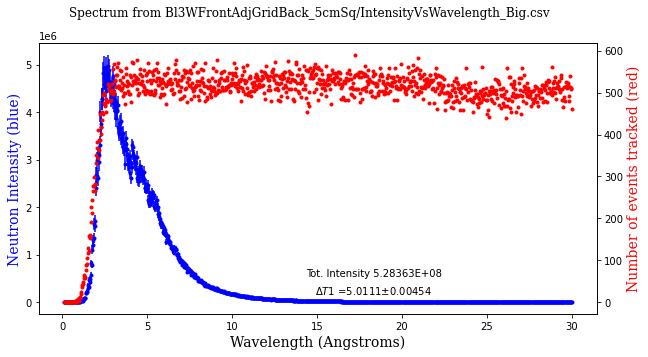

In [26]:
full = NSpectrum('Bl3WFrontAdjGridBack_5cmSq/IntensityVsWavelength_Big.csv')
fig1 = full.plot()
print(type(fig1), fig1)
fig1.savefig('Ref40ugc1.png', dpi=300)

There we see our reference spectrum and the 5.01s reference correction that we have been using.

Now let's tell the thing to recompute using the new thickness.

528363068.084805
<class 'matplotlib.figure.Figure'> Figure(720x360)


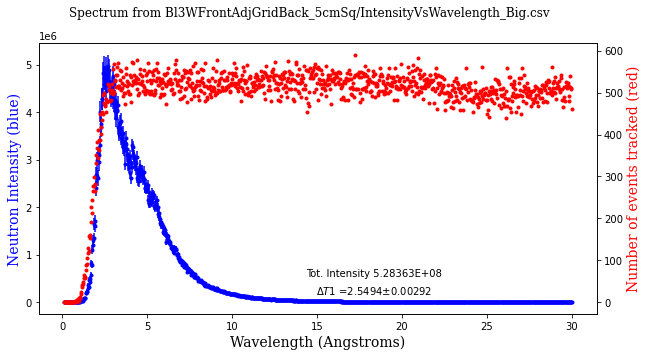

In [27]:
full._corr.SetRho(20.0)
fig2 = full.plot()
fig2.savefig('Ref20ugc1.png', dpi=300)

Well, *that's* kind of nice! The whole problem is only half as large as we thought. Even our worst quadrants in the 3x3 would now be within spec!

Now Jeremy says that the cold source upgrade will leave the flux at 4A unaffected, decrease below and increase above with the flux at 8A doubling. The simplest function that does that is a straight line, in particular the straight line $gain=\frac{\lambda}{4A}$.

579508527.9806796
<class 'matplotlib.figure.Figure'> Figure(720x360)


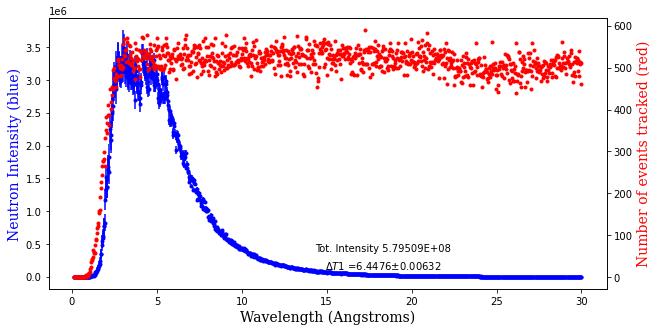

In [28]:
gain = full.data[:,0]/4
new = NSpectrum(clone=full)
new.data[:,1] = full.data[:,1] * gain
fig3 = new.plot()

579508527.9806796
<class 'matplotlib.figure.Figure'> Figure(720x360)


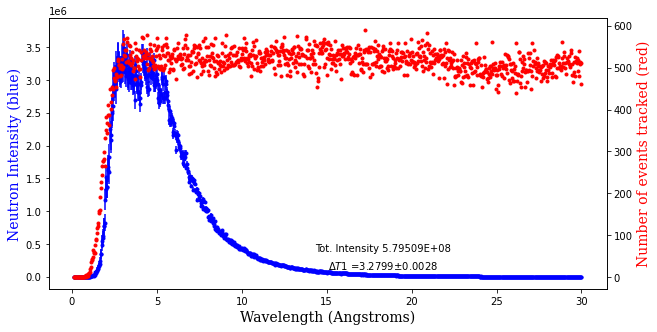

In [29]:
new._corr.SetRho(20.0)
fig4 = new.plot()
fig4.savefig('Upgraded20ugc1.png', dpi=300)

OK, well that was instructive. That is presumably a worst case (since it boosts the long-wavelength end by a factor of nearly 8) and we are still not back to the old BL1 correction.

It might be even more instructive to repeat the truncation measurement.

In [10]:
print(new._corr.CorrBC(new.data[:,0], new.data[:,1]))


3.279938214250983


In [11]:
l=950
print(new.data[l,0],new._corr.CorrBC(new.data[:l,0], new.data[:l,1]))

28.51995 3.27052911538945


In [12]:
l=900
print(new.data[l,0],new._corr.CorrBC(new.data[:l,0], new.data[:l,1]))

27.02495 3.2592470081681926


In [13]:
l=800
print(new.data[l,0],new._corr.CorrBC(new.data[:l,0], new.data[:l,1]))

24.03495 3.2287169722609304


In [14]:
l=700
print(new.data[l,0],new._corr.CorrBC(new.data[:l,0], new.data[:l,1]))

21.04495 3.181384904345902


There we go. We will need to get to at least 22A in order to be within the 0.1s.

And as a refresher here is the raw spectrum shown with the 20ug/cm^2 T1.

Spectrum has {self.n_data} channels
297132766433.07513
<class 'matplotlib.figure.Figure'> Figure(720x360)


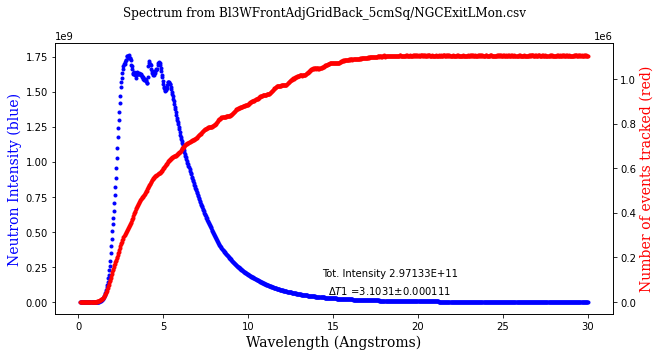

In [32]:
raw = NSpectrum('Bl3WFrontAdjGridBack_5cmSq/NGCExitLMon.csv')
raw._corr.SetRho(20.0)
fig5 = raw.plot()
fig5.savefig('Raw20ugc1.png', dpi=300)